In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

In [3]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display

import random



/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
!pip install --upgrade pip
!pip install -U sklearn
!pip install imblearn
!pip install textblob

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.1)
  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
    100% |████████████████████████████████| 174kB 6.5MB/s 
    100% |████████████████████████████████| 5.4MB 5.3MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2
    100% |████████████████████████████████| 645kB 5.9MB/s 


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

from sklearn.svm import SVC 
from xgboost.sklearn import XGBClassifier 
import itertools
from sklearn.neighbors import KNeighborsClassifier

#from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from textblob import Word
from sklearn.ensemble import VotingClassifier 



ImportError: ignored

# Prediction of Charge-Offs

We will consider the loan status as the response variable, a binary outcome for a loan with value 1 for fully paid and 0 for Charged Off.

We will work with data previously cleaned and augmented with census information. We will use a subset of loans which were fully paid or charged-off.

In [0]:
#df_loan_accepted_census_cleaned = pd.read_csv('df_loan_accepted_census_cleaned_closed_10.csv')
# 10% of all closed loans between 2007 and 2015, cleaned and augmented with census data - 73 MB
df_loan_accepted_census_cleaned = pd.read_csv('http://digintu.tech/tmp/cs109a/df_loan_accepted_census_cleaned_closed_2007-2015_10.csv') 
# 50% of all closed loans between 2007 and 2015, cleaned and augmented with census data - 364 MB
#df_loan_accepted_census_cleaned = pd.read_csv('http://digintu.tech/tmp/cs109a/df_loan_accepted_census_cleaned_closed_2007-2015_50.csv')

In [0]:
df_loan = df_loan_accepted_census_cleaned.copy()
df_loan = df_loan[df_loan.loan_status.isin(['Charged Off', 'Fully Paid'])]

## Features Selection

Our goal is now to do exploratory analysis using predictive models in order to find important features in closed loans.

Statistical tests can be used to select features that have the strongest relationship with the response variable. 

The Recursive Feature Elimination works by recursively removing variables and building a model on those variables that remain. Model accuracy is used to select the variables which contribute the most to the response.

In this section we use a model-based approach of features selection using bagged trees and PCA. 



### Manual features selection

The following list of predictors are those which we MUST not use since they are data gathered AFTER the loan is funded. The reason to exclude them is because these features will not be available in unseen future dataset. Those features are highly correlated to charged-off loans and would otherwise bias our results.

In [0]:
not_predictor = [
'chargeoff_within_12_mths',   
'collection_recovery_fee',
'debt_settlement_flag',
'debt_settlement_flag_date',
'deferral_term',
'funded_amnt_inv',
'funded_amnt',
'hardship_amount',
'hardship_dpd',
'hardship_end_date',
'hardship_flag',
'hardship_last_payment_amount',
'hardship_length',
'hardship_loan_status',
'hardship_payoff_balance_amount',
'hardship_reason',
'hardship_start_date',
'hardship_status',
'hardship_type',
'last_credit_pull_d',
'last_fico_range_high',
'last_fico_range_low',
'last_pymnt_amnt',
'last_pymnt_d',
'next_pymnt_d',
'orig_projected_additional_accrued_interest',
'out_prncp',
'out_prncp_inv',
'payment_plan_start_date',
'pymnt_plan',
'recoveries',
'settlement_amount',
'settlement_date',
'settlement_percentage',
'settlement_status',
'settlement_term',
'total_pymnt',
'total_pymnt_inv',
'total_rec_int',
'total_rec_late_fee',
'total_rec_prncp',
'verification_status'
]

We drop the index column.

In [0]:
not_predictor  += ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1']

We drop the id, URL

In [0]:
not_predictor  += ['id', 'url']

We drop the employment title, loan title and description, which contains too many distinct values and cannot be easily categorized.

In [0]:
not_predictor += ['emp_title', 'title', 'desc']

We drop the success flag since it contains the same information as the loan status.

In [0]:
not_predictor += ['success']

We remove following the issue date, quarter and year, which is less relevant for future loans, we only keep the issue month (Jan to Dec).

In [0]:
not_predictor += ['issue_q', 'issue_d']

The grade and subgrade are categories which the LendingClub match to interest rates. Although the categories are fixed, the interest rate can slightly change within each category over the time. 

The term is calculated using the amount and the interest rate.

It follows that `int_rate`, `grade`, `sub_grade` are correlated. Furthermore `loan_amnt`, `int_rate` and `term` define the `installment`. These relationships would bring collinearity into our model for features selection.

We will therefore work with `loan_amnt`, `sub_grade` and `term`. If it comes out that these features are important for predicting charge-off, we will conclude that their related variables `grade`, `int_rate`, and `installment` are also important.

In [0]:
not_predictor += ['grade', 'int_rate', 'installment']

As far as FICO is concerned, there are 6 variables. Four of them are determined at the initial loan application, thus we can use them. It doesn't seem that they are updated. 

These 2 are significant and collinear, so only one needs to be selected. We choose

    - fico_range_high
    - fico_range_low

These 2 are not so significant and, we believe are used for joint applications.

    - sec_app_fico_range_high
    - sec_app_fico_range_low


However, These two are created, and undoubtedly updated, throughout the loan life. They should not be used:

    - last_fico_range_high
    - last_fico_range_low

In [0]:
not_predictor += ['sec_app_fico_range_high', 'sec_app_fico_range_low', 'last_fico_range_high', 'last_fico_range_low']

**Correlation and redundancy**

Features-pairs which correlate by either -1 or +1 can be considered to be redundant. However High absolute correlation does not imply redundancy of features in the context of classification, see textbook Feature Extraction - Foundations and Applications by I. Guyon et al. (p.10, figure 2 (e)). Therefore we will have a closer look at each correlation.

In [0]:
#https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
def find_high_correlated_features(frame):
    new_corr = frame.corr()
    new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
    new_corr = new_corr.stack()
    print(new_corr[(new_corr > 0.80) | (new_corr < -0.80)])
    
predictor = list(set(df_loan_accepted_census_cleaned.columns.values)-set(not_predictor))
find_high_correlated_features(df_loan_accepted_census_cleaned[predictor])   

open_acc                    num_sats               0.901231
num_op_rev_tl               num_sats               0.838576
                            num_rev_tl_bal_gt_0    0.848086
fico_range_low              fico_range_high        1.000000
male_pct                    female_pct            -1.000000
num_actv_bc_tl              num_bc_sats            0.846392
                            num_rev_tl_bal_gt_0    0.831199
avg_cur_bal                 tot_hi_cred_lim        0.807931
tot_cur_bal                 tot_hi_cred_lim        0.977334
                            avg_cur_bal            0.843135
total_bc_limit              bc_open_to_buy         0.839302
total_il_high_credit_limit  total_bal_ex_mort      0.873770
num_actv_rev_tl             num_rev_tl_bal_gt_0    0.988788
                            num_op_rev_tl          0.844565
                            num_actv_bc_tl         0.833955
num_rev_accts               num_op_rev_tl          0.812922
num_bc_tl                   num_rev_acct

In [0]:
not_predictor += ['fico_range_low','male_pct','num_rev_tl_bal_gt_0', 'num_actv_rev_tl','open_il_12m','open_rv_12m','avg_cur_bal','tot_hi_cred_lim','num_bc_tl']

`fico_range_low` and `fico_range_low` are highly correlated. We keep the high value.

`male_pct` The probability for the borrower being male can be removed, since `female_pct` conveys that information as well.

The Number of revolving trades with balance >0 `num_rev_tl_bal_gt_0` and the Number of currently active revolving trades `num_actv_rev_tl` are highly correlated with the Number of currently active bankcard accounts `num_actv_bc_tl`. It is safe to remove the formers for our classification task for identifying fully paid loans from charged-off ones.

The number of open credit lines `open_acc` (preapproved loans between a financial institution and borrower that may be used repeatedly up to a certain limit and can subsequently be paid back prior to payments coming due) in the borrower's credit file is highly correlated with the Number of satisfactory accounts (good standing accounts that have been paid in full and on time) `num_sats`. We will keep both features.

`open_il_24m` and `open_il_12m` are the Number of installment accounts opened in past 24 and 12 months respectively. Both values are strongly correlated. We will consider 24 months period since it includes 12 months period. We will handle `open_rv_12m` and `open_rv_24m` in the same way (Number of revolving trades opened in past 12, resp. 24 months).

`tot_cur_bal`, `avg_cur_bal` Total and average current balance of all accounts are strongly related to `tot_hi_cred_lim`, Total high credit/credit limit. We will only keep the total current balance.

`num_rev_accts` Number of revolving accounts (account created by a lender to represent debts where the outstanding balance does not have to be paid in full every month by the borrower to the lender) and `num_bc_tl` Number of bankcard accounts are correlated. This is because credit cards are usually considered as revolving accounts. We assume that the number of revolving accounts better describe the risk for loans and we will remove the number of bankcard accounts.

`total_bal_ex_mort` Total credit balance excluding mortgage and `total_il_high_credit_limit` Total installment high credit/credit limit are correlated. With an installment account, the borrower pays back the loan plus interest by making regular payments for a fixed amount of time. We will keep both features.

`bc_open_to_buy` Total open to buy on revolving bankcards (credit cards) can be considered as a subset of `total_bc_limit` Total bankcard high credit/credit limit, but both information can differ in many situations. We keep both.

**Features values distribution**

For each remaining feature, we will plot the distribution of their values in both charged-off and fully paid categories. This will help us seing how they might impact the decision boundaries.

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


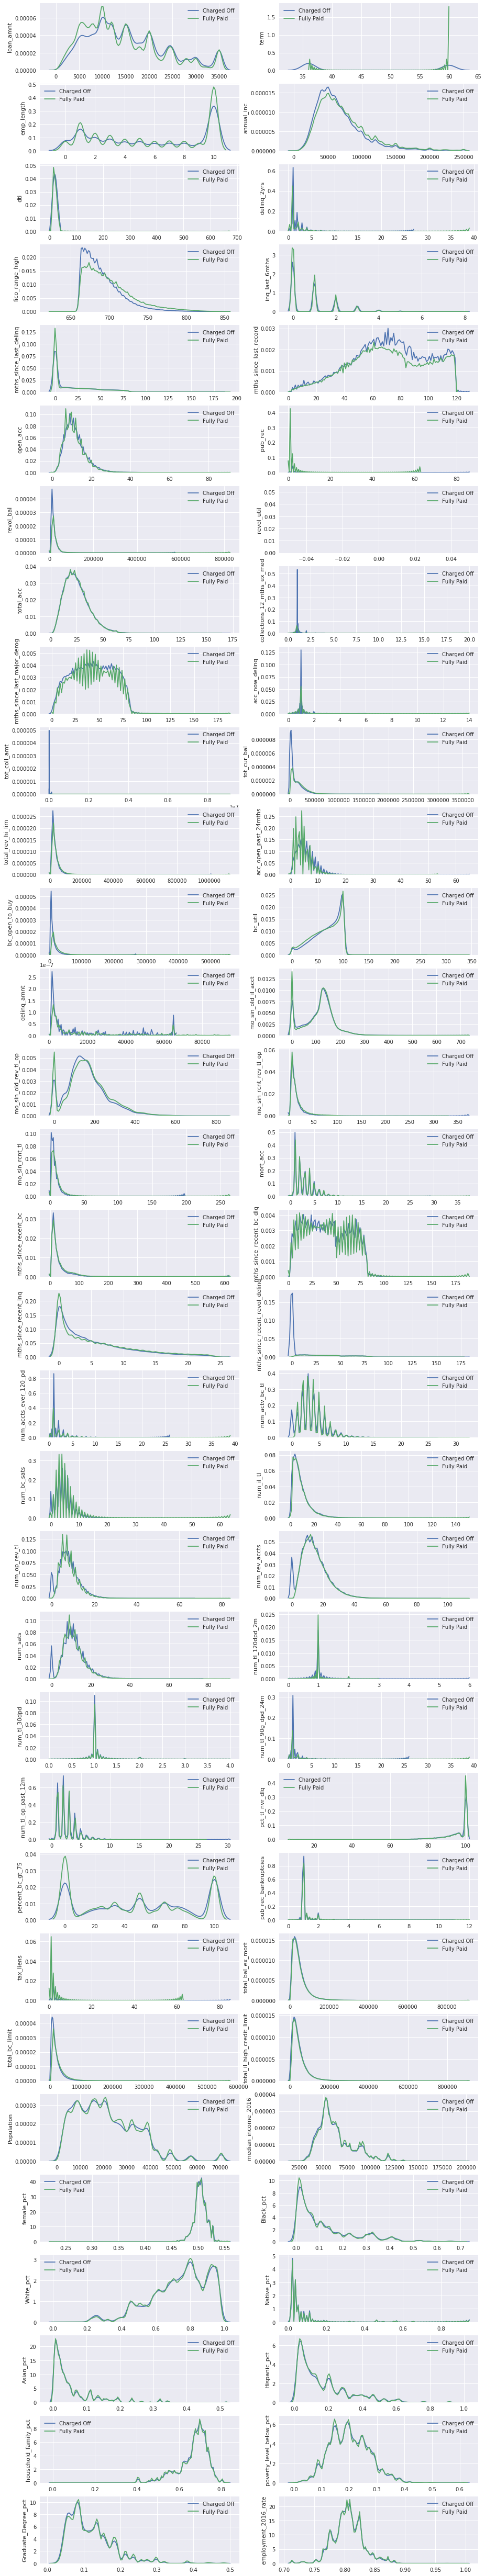

In [0]:
nb = 1
for var in [x for x in df_loan.columns.values if x not in not_predictor]:
    if df_loan[var].dtype == np.float64 or df_loan[var].dtype == np.int64:
        nb = nb + 1
fig, ax = plt.subplots(nb//2, 2, figsize=(15,90))
i = 0
for var in [x for x in df_loan.columns.values if x not in not_predictor]:
    if df_loan[var].dtype == np.float64 or df_loan[var].dtype == np.int64:
        sns.kdeplot(df_loan[df_loan.loan_status=='Charged Off'][var], label='Charged Off', ax=ax[i//2,i % 2])
        sns.kdeplot(df_loan[df_loan.loan_status!='Charged Off'][var], label='Fully Paid', ax=ax[i//2,i % 2])
        ax[i//2,i % 2].set_ylabel(var)
        i = i + 1
        

Looking at the plots above we see that the distribution for census-related features is almost the same accross both classes of loans. We will investigate those features closer using mode-based features selection in the next section.

**One-hot encoding**

We turn the loan status into a binary variable

In [0]:
df_loan.replace({'loan_status':{'Charged Off': 0, 'Fully Paid': 1}}, inplace=True)
df_loan.loan_status = df_loan.loan_status.astype('int')

We convert the `earliest_cr_line` feature to the number of years between the earliest credit line and the year when the loan was requested.

In [0]:
df_loan.earliest_cr_line = pd.to_datetime(df_loan.issue_d, format='%b-%Y').dt.to_period('Y') - pd.to_datetime(df_loan.earliest_cr_line, format='%b-%Y').dt.to_period('Y')
df_loan.earliest_cr_line = df_loan.earliest_cr_line.astype('int')

We turn categorical features into binary variables.

In [0]:
df_loan.replace({'term':{36: 1, 60: 0}},inplace=True)

In [0]:
df_loan = pd.get_dummies(df_loan, columns=['sub_grade', 'emp_length', 'home_ownership',
                                          'purpose', 'issue_m', 'addr_state', 'zip_code','earliest_cr_line'], drop_first=True)

**Remove irrelevant features**

Let's remove all indentified features above.

In [0]:
df_loan.drop(columns=list(set(not_predictor) & set(df_loan.columns.values)), inplace=True)

### Imbalanced Dataset

In [0]:
As we see below, the data is unbalanced, with Fully Paid loans being the majority class.

In [0]:
df_loan.loan_status.value_counts()

1    633159
0    146801
Name: loan_status, dtype: int64

`X` is the feature matrix. `Y` is the response vector.

In [0]:
X, Y = df_loan[df_loan.columns.difference(['loan_status'])], df_loan['loan_status']

We choose to split the whole dataset to 90% training, 10% test.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=9001)

Let's further split the training set into a 80% training and a 20% validation set.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=9001)

Let's reduce the dimension of a subset of the data using Principal Component Analysis (PCA) and display the imbalanced classes in a 2D plot.

In [0]:
X_train_subset = X_train[:100]
y_train_subset = y_train[:100]
pca = PCA(n_components=2)
X_train_subset = pca.fit_transform(X_train_subset)

In [0]:
y_train_subset.value_counts()

1    77
0    23
Name: loan_status, dtype: int64

In [0]:
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    labels = ['Charged Off', 'Fully Paid']
    for d, l, c, m in zip(labels, np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=d, marker=m, alpha=.5
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()

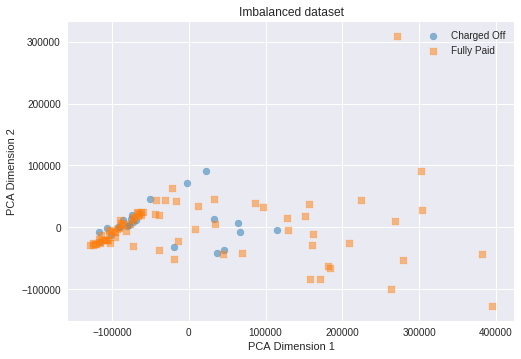

In [0]:
plot_2d_space(X_train_subset, y_train_subset, 'Imbalanced dataset')

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of either removing samples from the majority class (under-sampling) or adding more examples from the minority class (over-sampling). Both strategies can also be applied at the same time.

As shown below with under-sampling, we tend to loose valuable information, which can increase bias.

In [0]:
rus = RandomUnderSampler(return_indices=True)
X_train_subset_rus, y_train_subset_rus, id_rus = rus.fit_sample(X_train_subset, y_train_subset)
print(X_train_subset.shape[0] - X_train_subset_rus.shape[0], 'random samples removed')
plot_2d_space(X_train_subset_rus, y_train_subset_rus, 'Random under-sampling')

NameError: ignored

In over-sampling the most naive strategy is to generate new samples by randomly sampling with replacement the current available samples, which can cause overfitting.

54 random samples added


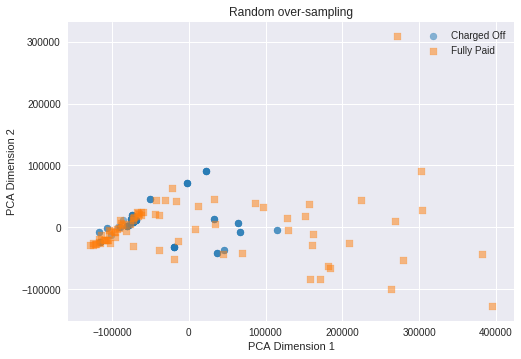

In [0]:
ros = RandomOverSampler()
X_train_subset_ros, y_train_subset_ros = ros.fit_sample(X_train_subset, y_train_subset)
print(X_train_subset_ros.shape[0] - X_train_subset.shape[0], 'random samples added')
plot_2d_space(X_train_subset_ros, y_train_subset_ros, 'Random over-sampling')

A number of more sophisticated resapling techniques have been proposed in the scientific literature, especially using the Python library imbalanced-learn (https://imbalanced-learn.org). SMOTE (Synthetic Minority Oversampling TEchnique) consists of creating new samples for the minority class, by picking a sample from that class and computing the k-nearest neighbors, then adding a new sample between the chosen sample and its neighbors.

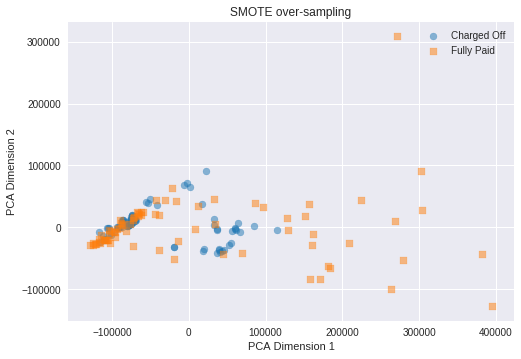

In [0]:
smote = SMOTE(ratio='minority')
X_train_subset_sm, y_train_subset_sm = smote.fit_sample(X_train_subset, y_train_subset)

plot_2d_space(X_train_subset_sm, y_train_subset_sm, 'SMOTE over-sampling')

We will use SMOTE to balance our training dataset.

In [0]:
X_train, y_train = smote.fit_sample(X_train, y_train)

In [0]:
print('The Charged-Off to Fully Paid ratio in the balanced training set is now: ', len(y_train[y_train==0])/len(y_train[y_train==1]))

The Charged-Off to Fully Paid ratio in the balanced training set is now:  1.0


In [0]:
#np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_train_upsampled_smote.csv', 
#           X_train, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))

In [0]:
#np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_train_upsampled_smote.csv', 
#           y_train, fmt='%.2f', delimiter=',', header='loan_status')

### Model-based features selection

We will use classifiers on the dataset in order to get a better understanding on how features are related to loan outcome as fully paid or unpaid.

The function below fit a random forest to the training set and display the classification accuracy on test.

In [0]:
def run_random_forest(X_train, y_train, X_val, y_val, size, depth):
    randomf = RandomForestClassifier(n_estimators=size, max_depth=depth).fit(X_train, y_train)
    accuracy_train = randomf.score(X_train, y_train)
    accuracy_val = np.mean(cross_val_score(randomf, X_val, y_val, cv=5, scoring='roc_auc'))
    print('RANDOM FOREST')
    print('Number of trees: ', size)
    print('Tree depth: ', depth)
    print('Accuracy, Training Set: {0:0.2%}'.format(accuracy_train))
    print('CV Accuracy, Val Set: {0:0.2%}'.format(accuracy_val))
    return accuracy_train, accuracy_val, randomf

We can now see how a forest of 100 depth-20 trees performs on our data.

In [0]:
rf_accuracy_train, rf_accuracy_val, randomf = run_random_forest(X_train, y_train, X_val, y_val, 100, 20)

RANDOM FOREST
Number of trees:  100
Tree depth:  20
Accuracy, Training Set: 94.77%
CV Accuracy, Val Set: 69.57%


In [0]:
print('CV Accuracy, Test Set: {0:0.2%}'.format(np.mean(cross_val_score(randomf, X_test, y_test, cv=5, scoring='roc_auc'))))

CV Accuracy, Test Set: 69.94%


Below we have a ranking of features as computed by our random forest, depending on their Gini importance in the prediction of loan outcome.

In [0]:
feature_importances = pd.DataFrame(randomf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False).reset_index().rename(columns={'index':'feature'})
feature_importances.head(10)

,feature,importance
0,term,0.072537
1,purpose_debt_consolidation,0.050164
2,inq_last_6mths,0.037292
3,emp_length_10,0.029273
4,acc_open_past_24mths,0.023912
5,num_tl_op_past_12m,0.023211
6,purpose_credit_card,0.023188
7,percent_bc_gt_75,0.018610
8,fico_range_high,0.017118
9,mths_since_recent_inq,0.016534


**Important Features**

We will now use SKLearn meta-transformet SelectFromModel to discard irrelevant features using the features importance produced by our random forest.

In [0]:
fs_model = SelectFromModel(randomf, prefit=True, threshold=0.004)
outcome = fs_model.get_support()
features_list_orig = X.columns.values
features_list_new = []
for i in range(0,len(features_list_orig)):
    if outcome[i]:
        features_list_new.append(features_list_orig[i])
print('{} features were selected from the {} original hot-encoded ones'.format(len(features_list_new), len(features_list_orig)))
print(features_list_new)

86 features were selected from the 1091 original hot-encoded ones
['Asian_pct', 'Black_pct', 'Graduate_Degree_pct', 'Hispanic_pct', 'Native_pct', 'Population', 'White_pct', 'acc_open_past_24mths', 'addr_state_CA', 'addr_state_TX', 'annual_inc', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'earliest_cr_line_12', 'earliest_cr_line_14', 'emp_length_1', 'emp_length_10', 'emp_length_2', 'emp_length_3', 'emp_length_5', 'employment_2016_rate', 'female_pct', 'fico_range_high', 'home_ownership_OWN', 'home_ownership_RENT', 'household_family_pct', 'inq_last_6mths', 'issue_m_Aug', 'issue_m_Dec', 'issue_m_Jan', 'issue_m_Jul', 'issue_m_Jun', 'issue_m_Mar', 'issue_m_May', 'issue_m_Nov', 'issue_m_Oct', 'issue_m_Sep', 'loan_amnt', 'median_income_2016', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_

In [0]:
loan_variables_selected = []
for col in df_loan_accepted_census_cleaned.columns:
    if len([s for s in features_list_new if col.startswith(s)])>0:
        loan_variables_selected.append(col)

print('After hot-decoding, they corresponds to the following {} features from the original dataset.'.format(len(loan_variables_selected)))
print('')
print(loan_variables_selected)

After hot-decoding, they corresponds to the following 54 features from the original dataset.

['loan_amnt', 'term', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'mths_since_last_major_derog', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'Population', 'median_income_2016', 'female_pct', 'Black_pct', 'White_pct', 'Native_pct', 'Asian_pct', 'Hispa

**Insights on features importance**

Looking at the results above, we can bring in following conclusions:

- The term is the most important element each investor has to care about. 68-months loans are highly risky.
- The purpose of loan for credit cards payment brings more confidence to an investor.
- Borrowers who have 10 or more years verified working experience are the most trustworthy investment.
- Home ownership plays a significant role.
- The state of California is a significant factor to be considered when looking at the likelihood of Charged-Off
- Lenders should look at financial KPIs such as inq_last_6mths, num_tl_op_past_12m and acc_open_past_24mths; not just at FICO score, which are less relevant than these KPIs.
- Debt-to-income ratio and annual income can be missleading, and shoudn't be always considered as the most important factors.
- The time of the year when the loan is requested is not so relevant.

**Design Matrix with important features**

We can now create the new design matrix using the identified important features.

In [0]:
X_train_new = fs_model.transform(X_train)
X_val_new = fs_model.transform(X_val)
X_test_new = fs_model.transform(X_test)

**Principal Components Analysis**

We are interested in reducing the dimension of our data further by analysing its principal components. This will allow us to compress the important features into a reduced number of components.

We first start with scaling the data.

In [0]:
scaler = StandardScaler().fit(X_train_new)
X_train_scaled = scaler.transform(X_train_new)
X_val_scaled = scaler.transform(X_val_new)
X_test_scaled = scaler.transform(X_test_new)

We decompose the scaled data with PCA

In [0]:
n = X_train_new.shape[1]
pca_fit = PCA(n).fit(X_train_scaled)

In the plot below, we see that the dimension can be reduced to the number of components which explain at least 80% of variance in the data.

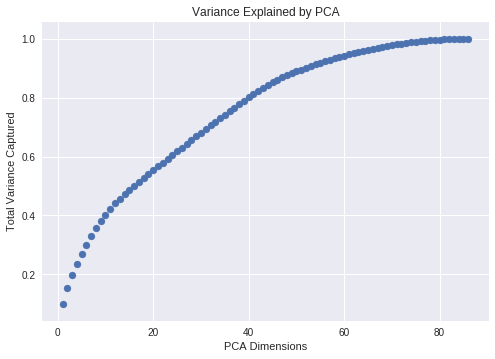

In [0]:
pca_var = np.cumsum(pca_fit.explained_variance_ratio_)
plt.scatter(range(1,n+1),pca_var)
plt.xlabel("PCA Dimensions")
plt.ylabel("Total Variance Captured")
plt.title("Variance Explained by PCA");

We can now rebuild our design matrix using the PCA components.

In [0]:
pca_fit = PCA(40).fit(X_train_scaled)
X_train_scaled_pca = pca_fit.transform(X_train_scaled)
X_val_scaled_pca = pca_fit.transform(X_val_scaled)
X_test_scaled_pca = pca_fit.transform(X_test_scaled)

## Classification Models

In the previous section we used a model-based approach for identifying the important features which most probably determine the failure or success of a loan.

Using the features selected, we will now investigate the performance of several models on the validation set via cross-validation. Each model will be trained on the training set. We will also check if dimension reduction via PCA improves the accuracy. 

At the end we will investigate if ensemble technique via stacking of base learners improves classification results.

### Training Data

For performance reason, we can resample the data and use a smaller volume for training our models. 

There are three versions: the original set, scaled set, scaled set with PCA.


In [0]:
print(" We have {} samples with {} features in our datasets.").format(X_train_new.shape[0], X_train_new.shape[1]))

(90966, 1091)

In [0]:
from sklearn.utils import resample

frac = 1

X_train_small, y_train_small = resample(X_train_new, y_train, n_samples=round(y_train.shape[0]*frac))
X_val_small, y_val_small = resample(X_val_new, y_val, n_samples=round(y_train.shape[0]*frac))
X_test_small, y_test_small = resample(X_test_new, y_test, n_samples=round(y_train.shape[0]*frac))


"""np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_train_upsampled_smote_10.csv', 
           X_train_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_val_upsampled_smote_10.csv', 
           X_val_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_test_upsampled_smote_10.csv', 
           X_test_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_train_upsampled_smote_10.csv', 
           y_train_small, fmt='%.2f', delimiter=',', header='loan_status')
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_val_upsampled_smote_10.csv', 
           y_val_small, fmt='%.2f', delimiter=',', header='loan_status')
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_test_upsampled_smote_10.csv', 
           y_test_small, fmt='%.2f', delimiter=',', header='loan_status')
"""

X_train_scaled_small, y_train_scaled_small = resample(X_train_scaled, y_train, n_samples=round(y_train.shape[0]*frac))
X_val_scaled_small, y_val_scaled_small = resample(X_val_scaled, y_val, n_samples=round(y_train.shape[0]*frac))
X_test_scaled_small, y_test_scaled_small = resample(X_test_scaled, y_test, n_samples=round(y_train.shape[0]*frac))

"""
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_train_scaled_upsampled_smote_10.csv', 
           X_train_scaled_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_val_scaled_upsampled_smote_10.csv', 
           X_val_scaled_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_test_scaled_upsampled_smote_10.csv', 
           X_test_scaled_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_train_scaled_upsampled_smote_10.csv', 
           y_train_scaled_small, fmt='%.2f', delimiter=',', header='loan_status')
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_val_scaled_upsampled_smote_10.csv', 
           y_val_scaled_small, fmt='%.2f', delimiter=',', header='loan_status')
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_test_scaled_upsampled_smote_10.csv', 
           y_test_scaled_small, fmt='%.2f', delimiter=',', header='loan_status')
"""

X_train_scaled_pca_small, y_train_scaled_pca_small = resample(X_train_scaled_pca, y_train, n_samples=round(y_train.shape[0]*frac))
X_val_scaled_pca_small, y_val_scaled_pca_small = resample(X_val_scaled_pca, y_val, n_samples=round(y_train.shape[0]*frac))
X_test_scaled_pca_small, y_test_scaled_pca_small = resample(X_test_scaled_pca, y_test, n_samples=round(y_train.shape[0]*frac))

"""
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_train_scaled_pca_upsampled_smote_10.csv', 
           X_train_scaled_pca_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_val_scaled_pca_upsampled_smote_10.csv', 
           X_val_scaled_pca_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_test_scaled_pca_upsampled_smote_10.csv', 
           X_test_scaled_pca_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_train_scaled_pca_upsampled_smote_10.csv', 
           y_train_scaled_pca_small, fmt='%.2f', delimiter=',', header='loan_status')
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_val_scaled_pca_upsampled_smote_10.csv', 
           y_val_scaled_pca_small, fmt='%.2f', delimiter=',', header='loan_status')
np.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_test_scaled_pca_upsampled_smote_10.csv', 
           y_test_scaled_pca_small, fmt='%.2f', delimiter=',', header='loan_status')
"""

"\nnp.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_train_scaled_pca_upsampled_smote_10.csv', \n           X_train_scaled_pca_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))\nnp.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_val_scaled_pca_upsampled_smote_10.csv', \n           X_val_scaled_pca_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))\nnp.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_X_test_scaled_pca_upsampled_smote_10.csv', \n           X_test_scaled_pca_small, fmt='%.2f', delimiter=',', header=','.join(X.columns.values))\nnp.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_train_scaled_pca_upsampled_smote_10.csv', \n           y_train_scaled_pca_small, fmt='%.2f', delimiter=',', header='loan_status')\nnp.savetxt('df_loan_accepted_census_cleaned_closed_2007-2015_y_val_scaled_pca_upsampled_smote_10.csv', \n           y_val_scaled_pca_small, fmt='%.2f', delimiter=',', header='loan_status')


### Scoring

We will work with the following metrics:

- **Recall or Sensitivity or TPR (True Positive Rate)**: Number of loans correctly identified as positive (fully paid) out of total true positives - TP/(TP+FN)
    
- **Specificity or TNR (True Negative Rate)**: Number of loans correctly identified as negative (charged-off) out of total negatives - TN/(TN+FP)

- **Precision**: Number of loans correctly identified as positive (fully paid) out of total items identified as positive - TP/(TP+FP)
    
- **False Positive Rate or Type I Error**: Number of loans wrongly identified as positive (fully paid) out of total true negatives - FP/(FP+TN)
    
- **False Negative Rate or Type II Error**: Number of loans wrongly identified as negative (charged-off) out of total true positives - FN/(FN+TP)

- A **Confusion Matrix**: visual representation of the number of TP, TN, FP and FN.

- **Accuracy**: Percentage of total items classified correctly - (TP+TN)/(N+P)

- **F1 Score**: Harmonic mean of precision and recall given by - F1 = 2xPrecisionxRecall /(Precision + Recall)

- **ROC-AUC Score**: Area under curve of sensitivity (TPR) vs. specificity (TNR).

- **Log-loss**: Probabilistic confidence of accuracy. High value of log-loss means that the absolute probabilities have big difference from actual labels.  

**Scoring in investment strategy**

https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428

If we choose an investment strategy that uses absolute probabilistic difference, then we will  look at log-loss with care. If the final class prediction is the most important outcome and we don’t want to tune probability threshold, we will rather use AUC score. But if the threshold is well tuned, then F1 will be the scoring to use.

In loan classification, where negative labels (charged-offs) are few, we would like our model to predict negative classes correctly and hence we will sometime prefer those models which are able to classify these negative labels. Log-loss usually fails to identify model which produces too many false negatives because the log-loss function is symmetric and does not differentiate between classes.  Both F1 score and ROC-AUC score can perform well for class imbalance. F1 is better suit for situations where the positive class is small. Since an investor would care more about the minority class (charged-off loans) in number independent of the fact whether it is positive or negative, then we think that ROC-AUC score would make sense as benchmark measure.

**Helper functions for scoring metrics**

In [0]:
# dataframe where we track all cross-validation scoring metrics
df_cv_scores = pd.DataFrame({'model':['dummy'], 'accuracy':[0], 'neg_log_loss':[0], 'f1':[0], 'roc_auc':[0]}, 
                            columns=['accuracy','neg_log_loss','f1','roc_auc'], index=['model'])

In [0]:
# function for computing 5-fold cross-validation scoring scores
def predict_evaluate_cv(model, X, y):
    score_accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    score_log_loss = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss').mean()
    score_f1 = cross_val_score(model, X, y, cv=5, scoring='f1').mean()
    score_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    df_cv_scores.loc[model.__class__.__name__] = [score_accuracy, -score_log_loss, score_f1, score_auc]
    print('K-fold cross-validation results:')
    print(model.__class__.__name__+" average accuracy is %2.3f" % score_accuracy)
    print(model.__class__.__name__+" average log_loss is %2.3f" % -score_log_loss)
    print(model.__class__.__name__+" average F1 is %2.3f" % score_f1)
    print(model.__class__.__name__+" average auc is %2.3f" % score_auc)

In [0]:
# function for computing the confusion matrix
def predict_evaluate_cm(model, X, y):
    classes = ['Fully Paid', 'Charged-Off']
    y_true, y_pred = y, model.predict(X)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #print(classification_report(y,y_pred))

In [0]:
# function for compution the roc plot
def predict_evaluate_roc(model, X, y):
    # source https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    [fpr, tpr, thr] = roc_curve(y, y_pred_proba)

    idx = np.min(np.where(tpr > 0.95))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [0]:
# global function for fitting, cross-validating and evaluating a given classifier
def fit_predict_evaluate(model, Xtrain, ytrain, Xval, yval):
    model.fit(Xtrain, ytrain)
    print(model.__class__.__name__+":")
    print('Accuracy, Training Set: {0:0.2%}'.format(model.score(Xtrain, ytrain)))
    predict_evaluate_cv(model, Xval, yval)
    predict_evaluate_cm(model, Xval, yval)
    predict_evaluate_roc(model, Xval, yval)

## Logistic Regression

We will start with a simple logistic regression model for predicting loan charge-off. The penalty parameter is found via cross-validation on the training set.

In [0]:
log_reg = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
    )

LogisticRegressionCV:
Accuracy, Training Set: 67.51%
K-fold cross-validation results:
LogisticRegressionCV average accuracy is 0.816
LogisticRegressionCV average log_loss is 0.433
LogisticRegressionCV average F1 is 0.897
LogisticRegressionCV average auc is 0.723


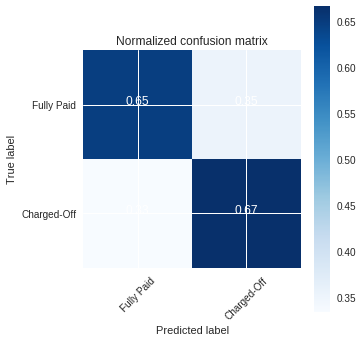

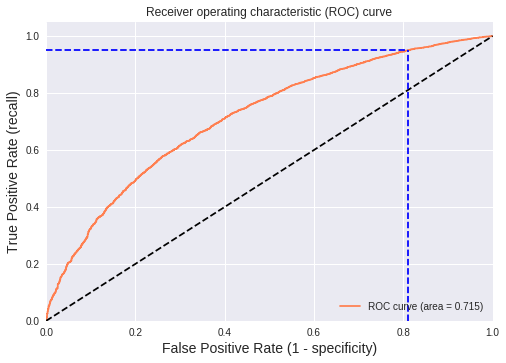

Using a threshold of 0.227 guarantees a sensitivity of 0.950 and a specificity of 0.188, i.e. a false positive rate of 81.16%.


In [0]:
fit_predict_evaluate(log_reg, X_train_scaled_small, y_train_scaled_small, X_val_scaled_small, y_val_scaled_small)

AUC is 0.80, there is 80% of chance that the logistic regression model will be able to distinguish between fully paid loans and charged-off loans.

**Logistic Regression with PCA**

LogisticRegressionCV:
Accuracy, Training Set: 71.32%


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


K-fold cross-validation results:
LogisticRegressionCV average accuracy is 0.812
LogisticRegressionCV average log_loss is 0.444
LogisticRegressionCV average F1 is 0.896
LogisticRegressionCV average auc is 0.701


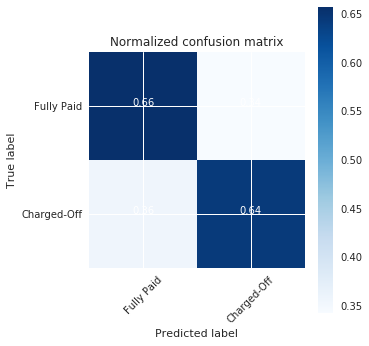

              precision    recall  f1-score   support

           0       0.30      0.66      0.41     17137
           1       0.89      0.64      0.75     74046

   micro avg       0.65      0.65      0.65     91183
   macro avg       0.59      0.65      0.58     91183
weighted avg       0.78      0.65      0.68     91183



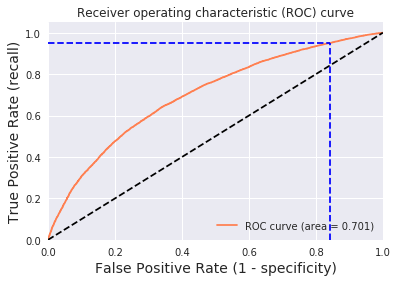

Using a threshold of 0.252 guarantees a sensitivity of 0.950 and a specificity of 0.159, i.e. a false positive rate of 84.07%.


In [0]:
fit_predict_evaluate(log_reg, X_train_scaled_pca_small, y_train_scaled_pca_small, X_val_scaled_pca_small, y_val_scaled_pca_small)

PCA causes a decrease in average AUC.

## Random Forest

We will now rebuilt our random forest classifier, this time using the important features.

In [0]:
randomf_optim = RandomForestClassifier(n_estimators=200, max_depth=30)

RandomForestClassifier:
Accuracy, Training Set: 100.00%
K-fold cross-validation results:
RandomForestClassifier average accuracy is 0.999
RandomForestClassifier average log_loss is 0.015
RandomForestClassifier average F1 is 0.999
RandomForestClassifier average auc is 1.000


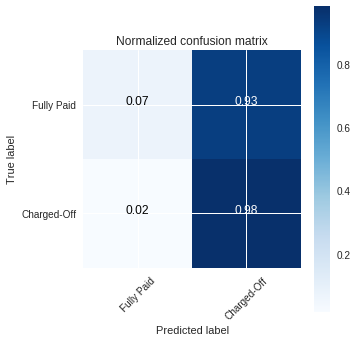

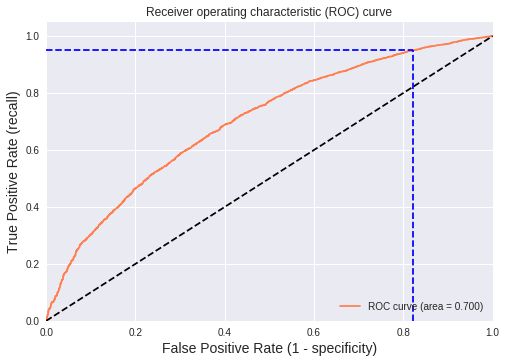

Using a threshold of 0.565 guarantees a sensitivity of 0.951 and a specificity of 0.178, i.e. a false positive rate of 82.18%.


In [0]:
fit_predict_evaluate(randomf_optim, X_train_small, y_train_small, X_val_small, y_val_small)

The random forest classifier gives the best accuracy so far.

## Boosting

In this section, we try the boosting technique for loan default prediction.

In [0]:
ab_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7), n_estimators=60, learning_rate=0.05)

In [0]:
fit_predict_evaluate(ab_model, X_train_small, y_train_small, X_val_small, y_val_small)

AdaBoostClassifier:
Accuracy, Training Set: 90.78%


In [0]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
train_scores = list(ab_model.staged_score(X_train,y_train))
test_scores = list(ab_model.staged_score(X_test, y_test))
ax[0].plot(train_scores,label='depth-{}'.format(depth))
ax[1].plot(test_scores,label='depth-{}'.format(depth))
ax[0].set_xlabel('number of iterations', fontsize=12)
ax[1].set_xlabel('number of iterations', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_title("Variation of Accuracy with Iterations (training set)", fontsize=14)
ax[1].set_title("Variation of Accuracy with Iterations (validation set)", fontsize=14)
ax[0].legend(fontsize=12);
ax[1].legend(fontsize=12);    

### XG Boosting

In [0]:
xgb_model = XGBClassifier(learningrate =0.01, nestimators=100,
                    maxdepth=4, minchildweight=4, subsample=0.8, colsamplebytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scaleposweight=2,
                    seed=27)

XGBClassifier:
Accuracy, Training Set: 88.29%
K-fold cross-validation results:
XGBClassifier average accuracy is 0.813
XGBClassifier average log_loss is 0.438
XGBClassifier average F1 is 0.896
XGBClassifier average auc is 0.717


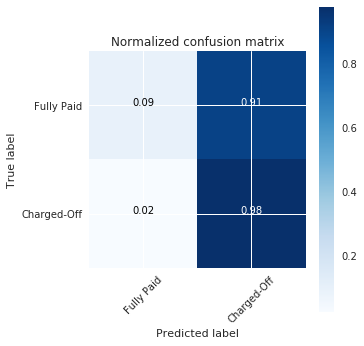

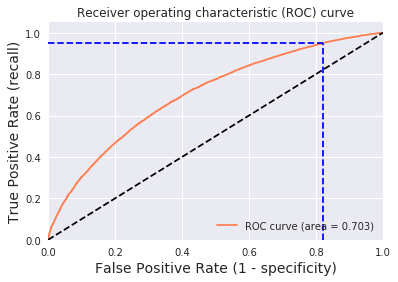

Using a threshold of 0.559 guarantees a sensitivity of 0.950 and a specificity of 0.180, i.e. a false positive rate of 81.98%.


In [0]:
fit_predict_evaluate(xgb_model, X_train_small, y_train_small, X_val_small, y_val_small)

## SVM

In [0]:
svm_model = SVC(gamma=0.1, C=0.01, kernel="linear")

In [0]:
fit_predict_evaluate(svm_model, X_train_scaled_small, y_train_scaled_small, X_val_scaled_small, y_val_scaled_small)

SVC:
Accuracy, Training Set: 66.88%


AttributeError: predict_proba is not available when  probability=False

## QDA

In this section we try a QDA model.

In [0]:
qda_model = QuadraticDiscriminantAnalysis()

QuadraticDiscriminantAnalysis:
Accuracy, Training Set: 65.52%
K-fold cross-validation results:
QuadraticDiscriminantAnalysis average accuracy is 0.658
QuadraticDiscriminantAnalysis average log_loss is 1.383
QuadraticDiscriminantAnalysis average F1 is 0.760
QuadraticDiscriminantAnalysis average auc is 0.679


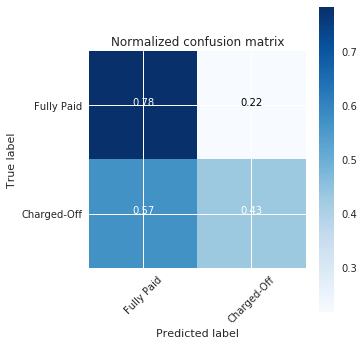

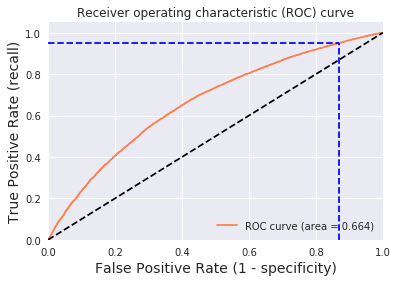

Using a threshold of 0.000 guarantees a sensitivity of 0.950 and a specificity of 0.131, i.e. a false positive rate of 86.87%.


In [0]:
fit_predict_evaluate(qda_model, X_train_scaled_small, y_train_scaled_small, X_val_scaled_small, y_val_scaled_small)

## KNN

In [0]:
knn_model = KNeighborsClassifier(n_neighbors=3)

In [0]:
fit_predict_evaluate(knn_model, X_train_scaled_small, y_train_scaled_small, X_val_scaled_small, y_val_scaled_small)

## Loan Description

https://www.thecut.com/2017/05/what-the-words-you-use-in-a-loan-application-reveal.html

Some studies suggest that words used on loan applications can predict the likelihood of charge-off.
In this section we use natural language processing algorithms to extract features from the loan title and description filled in by the borrower when requesting the loan. We then use a Naive Bayes classifier and a random forest for this task.

In [0]:
def clean_text(text):
    #https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
    # lower case
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    # remove punctuation
    text = text.str.replace('[^\w\s]','') 
    # remove stop words    
    stop = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    # correct spelling
    #from textblob import TextBlob
    #text = text.apply(lambda x: str(TextBlob(x).correct()))
    # lemmatization     
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return text

In [0]:
#>>> import nltk
#>>> nltk.download('wordnet')
#>>> nltk.download('stopwords')

df_desc = df_loan_accepted_census_cleaned.copy()
df_desc = df_desc[['title', 'desc', 'loan_status']]
df_desc.fillna('N/A', inplace=True)
df_desc['desc'] = df_desc['desc'] + ' - ' + df_desc['title']
df_desc = df_desc[df_desc.loan_status.isin(['Charged Off', 'Fully Paid'])]
df_desc.replace({'loan_status':{'Charged Off': 0, 'Fully Paid': 1}}, inplace=True)
df_desc.loan_status = df_desc.loan_status.astype('int')
df_desc.desc = clean_text(df_desc.desc).str.replace('na','')

In [0]:
X_desc = df_desc.title
y_desc = df_desc.loan_status
X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(X_desc, y_desc, test_size= 0.2, random_state=13)

In [0]:
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(1, 1),
    max_features=30000)

# fit and transform on it the training features
word_vectorizer.fit(X_train_desc)
X_train_desc_features = word_vectorizer.transform(X_train_desc)

#transform the test features to sparse matrix
X_test_desc_features = word_vectorizer.transform(X_test_desc)

In [0]:
X_test_desc_features.shape

(155992, 13704)

In [0]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

MultinomialNB:
Accuracy, Training Set: 81.38%
K-fold cross-validation results:
MultinomialNB average accuracy is 0.811
MultinomialNB average log_loss is 0.493
MultinomialNB average F1 is 0.896
MultinomialNB average auc is 0.534


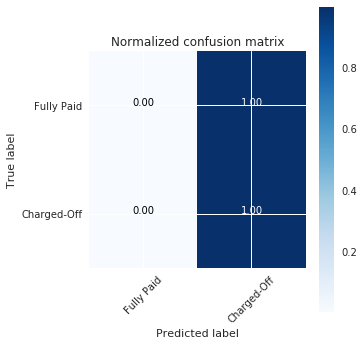

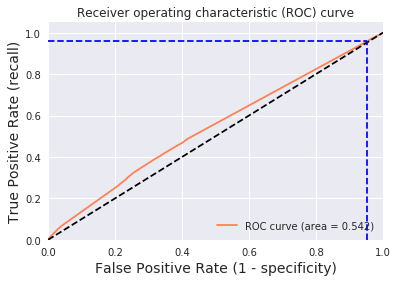

Using a threshold of 0.798 guarantees a sensitivity of 0.958 and a specificity of 0.047, i.e. a false positive rate of 95.32%.


In [0]:
fit_predict_evaluate(clf, X_train_desc_features, y_train_desc, X_test_desc_features, y_test_desc)

RandomForestClassifier:
Accuracy, Training Set: 81.17%
K-fold cross-validation results:
RandomForestClassifier average accuracy is 0.812
RandomForestClassifier average log_loss is 0.482
RandomForestClassifier average F1 is 0.896
RandomForestClassifier average auc is 0.543


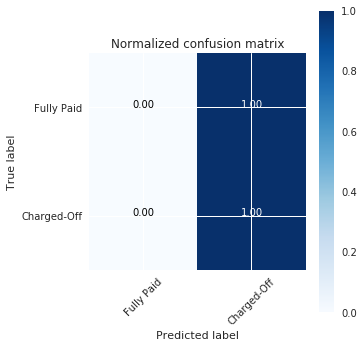

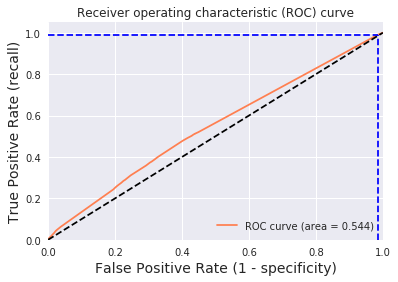

Using a threshold of 0.805 guarantees a sensitivity of 0.991 and a specificity of 0.014, i.e. a false positive rate of 98.56%.


In [0]:
rf_desc = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=0)
fit_predict_evaluate(rf_desc, X_train_desc_features, y_train_desc, X_test_desc_features, y_test_desc)

Both Naive Bayes and random forest did not find enough information that would clearly distinguish the two classes of loans.

## Stacking

We should consider stacking all the models obtained for achieving better prediction accuracy.

We begin with this simple approach of averaging base models. 

In [0]:
voting_clf = VotingClassifier(estimators=[
    ('rf', randomf_optim), 
    ('lr', log_reg),
    ('qda', qda_model)], voting='soft', flatten_transform=True)
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig...rs=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001))],
         flatten_transform=True, n_jobs=None, voting='soft', weights=None)

In [0]:
fit_predict_evaluate(voting_clf, X_train_scaled_small, y_train_scaled_small, X_val_scaled_small, y_val_scaled_small)

It seems even the simplest stacking approach improved the score of our best base learner. This encourages us to go further and explore a less simple stacking approach.

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

In [0]:
#https://towardsdatascience.com/predicting-loan-repayment-5df4e0023e92
models = {'rf': randomf_optim, 
        'lr': log_reg,
        'qda': qda_model}

We previously split the total training set into 5 disjoint folds (4 training and 1 holdout). We train the base models on the training folds and we predict on the holdout fold.

In [0]:
# Build first stack of base learners
first_stack = make_pipeline(voting_clf, FunctionTransformer(lambda X: X[:, 1::2]))
# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack, X_train_scaled_small, y_train_scaled_small, cv=5, method="transform")

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/ubuntu/anaconda3/e

In [0]:
# Refit the first stack on the full training set
first_stack.fit(X_train_scaled_small, y_train_scaled_small)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [0]:
# Fit the meta learner
logreg_clf = LogisticRegression(penalty="l2", C=100, fit_intercept=True)
second_stack = logreg_clf.fit(meta_features, y_train_scaled_small)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


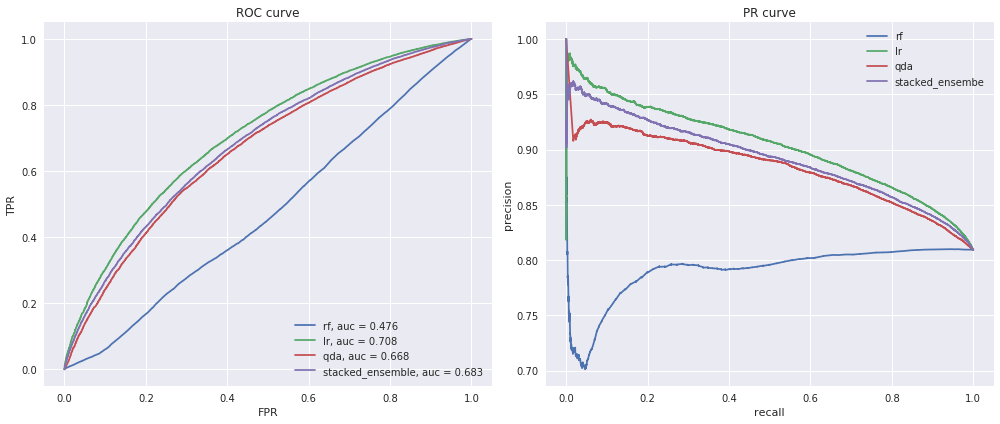

In [0]:
# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
    model_probs = model.predict_proba(X_val_scaled_small)[:, 1:]
    model_auc_score = roc_auc_score(y_val_scaled_small, model_probs)
    fpr, tpr, _ = roc_curve(y_val_scaled_small, model_probs)
    precision, recall, _ = precision_recall_curve(y_val_scaled_small, model_probs)
    axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
    axes[1].plot(recall, precision, label=f"{name}")

stacked_probs = second_stack.predict_proba(first_stack.transform(X_val_scaled_small))[:, 1:]
stacked_auc_score = roc_auc_score(y_val_scaled_small, stacked_probs)
fpr, tpr, _ = roc_curve(y_val_scaled_small, stacked_probs)
precision, recall, _ = precision_recall_curve(y_val_scaled_small, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

Stacking did not improve the accuracy of our three base learners.

## Models Benchmark

All models investigated in this project are compared in the table below. The performance was achieved on the validation set using 5-fold cross-validation.

In [0]:
df_cv_scores

,accuracy,neg_log_loss,f1,roc_auc
model,0.000000,0.000000,0.000000,0.000000
LogisticRegressionCV,0.812312,-0.442843,0.894996,0.708746
QuadraticDiscriminantAnalysis,0.657611,1.382761,0.759832,0.678648
XGBClassifier,0.813156,0.438469,0.895662,0.717397
MultinomialNB,0.810913,0.492669,0.895557,0.533533
RandomForestClassifier,0.972509,0.126344,0.986063,0.616578


**Performance on test set**

# Investment Strategy

Given the results from the previous section, we can know formulate investment strategies.

1. only A1, 36 month loans - that would be for CONSERVATIVE INVESTORS such as retirees
2. only A1-A5, 36 month loans - a little less conservative
3. only E1-E5, high risk and potentially high-reward (results will confirm or not) for SPECULATION

The function below fits a predictive model with a subset of data depending on the invesment strategy (sub grades and term), and it displays cross-validation score.

In [0]:
def simulate_strategy(df_loan_strategy, sub_grades=['A1'], term=36):
    df_loan_strategy = df_loan_strategy[df_loan_strategy.loan_status.isin(['Charged Off', 'Fully Paid'])]
    df_loan_strategy.replace({'loan_status':{'Charged Off': 0, 'Fully Paid': 1}}, inplace=True)
    df_loan_strategy.loan_status = df_loan_strategy.loan_status.astype('int')
    df_loan_strategy = df_loan_strategy[df_loan_strategy.term==term]
    df_loan_strategy = df_loan_strategy[df_loan_strategy.sub_grade.isin(sub_grades)]
    not_predictor_strategy = not_predictor + ['sub_grade','issue_m', 'addr_state', 'zip_code','earliest_cr_line']
    df_loan_strategy.drop(columns=list(set(not_predictor_strategy) & set(df_loan_strategy.columns.values)), inplace=True)
    df_loan_strategy = pd.get_dummies(df_loan_strategy, columns=['emp_length', 'home_ownership'], drop_first=True)
    df_loan_strategy = df_loan_strategy[list(set(features_list_new).intersection(set(df_loan_strategy.columns.values)))+['loan_status']]
    #df_loan_strategy = df_loan_strategy.sample(frac=.1)
    X, Y = df_loan_strategy[df_loan_strategy.columns.difference(['loan_status'])], df_loan_strategy['loan_status']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=9001)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=9001)
    smote = SMOTE(ratio='minority')
    X_train, y_train = smote.fit_sample(X_train, y_train)
    #ros = RandomOverSampler()
    #X_train, y_train = ros.fit_sample(X_train, y_train)
    model = RandomForestClassifier(n_estimators=100, max_depth=10) # WILLIAM - change this model if necessary
    fit_predict_evaluate(model, X_train, y_train, X_val, y_val)
    return X_train, y_train, X_val, y_val, X_test, y_test

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:4550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


RandomForestClassifier:
Accuracy, Training Set: 97.74%
K-fold cross-validation results:
RandomForestClassifier average accuracy is 0.973
RandomForestClassifier average log_loss is 0.126
RandomForestClassifier average F1 is 0.986
RandomForestClassifier average auc is 0.617


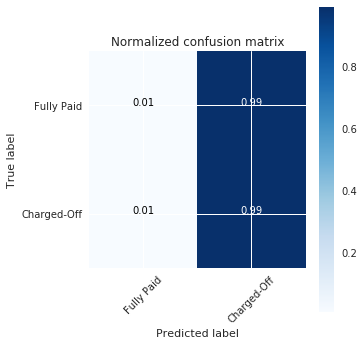

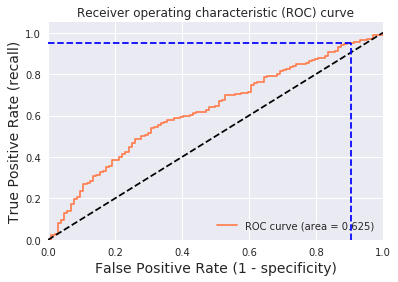

Using a threshold of 0.607 guarantees a sensitivity of 0.951 and a specificity of 0.096, i.e. a false positive rate of 90.38%.


ValueError: not enough values to unpack (expected 7, got 6)

In [0]:
df_loan_strategy = df_loan_accepted_census_cleaned.copy()
X_train_strategy, y_train_strategy, X_val_strategy, y_val_strategy, X_test_strategy, y_test_strategy = simulate_strategy(df_loan_strategy, sub_grades=['A1'], term=36)